In [1]:
import os
import copy

import torch
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib
import matplotlib.pyplot as plt

from src.utils import load_pickle_obj
from src.relative_embedding import (AnchorDescriptors,
                                    DescriptorColors,
                                    construct_relative_embeddings)

from src.graph import description_graph
from src.models import (ALBERT_embeddings,
                        BERT_embeddings,
                        BART_embeddings,
                        GPT2_embeddings,
                        RoBERTa_embeddings,
                        T5_embeddings)

In [2]:
def _remove_matrix_row_by_indices(matrix, removed_indices):
    replaced_matrix = []
    for idx in range(matrix.shape[0]):
        if idx in removed_indices:
            continue

        replaced_matrix.append(matrix[idx])

    replaced_matrix = np.stack(replaced_matrix, axis = 0)
    return replaced_matrix

def _remove_list_element_by_indices(list_obj, removed_indices):
    replaced_list = []
    for idx in range(len(list_obj)):
        if idx in removed_indices:
            continue

        replaced_list.append(list_obj[idx])

    return replaced_list

def plot_relative_embeddings(model_embeddings, 
                             target_embedding, 
                             colored_descriptions, 
                             colors,
                             dimension_reduction = 'tsne',
                             tsne_seed = 42, 
                             plot_OOD = True):
    
    assert dimension_reduction in ['pca', 'tsne']
    
    colors = copy.deepcopy(colors)
    colors['black'] = (0, 0, 0)
    for color in colors:
        colors[color] =  tuple([value / 255 for value in colors[color]])
    
    all_descritpions = []
    for color in colored_descriptions:
        all_descritpions += colored_descriptions[color]
        
    embeddings = {}
    for des_name in all_descritpions:
        for idx in model_embeddings:
            if des_name == model_embeddings[idx]['description']:
                embeddings[des_name] = model_embeddings[idx][target_embedding]
                break
                
    assert len(embeddings) == len(all_descritpions)
    
    ood_indices, idx = [], 0
    data_matrix, groups = [], []
    for des_name in embeddings:
        detect_color = 'black'
        data_matrix.append(embeddings[des_name])
        for color in colored_descriptions:
            if des_name in colored_descriptions[color]:
                detect_color = color
                break

        if detect_color == 'OOD':
            ood_indices.append(idx)
            
        groups.append(detect_color)
        idx += 1
        
    data_matrix = torch.stack(data_matrix).numpy()
    if dimension_reduction == 'pca':
        pca = PCA(n_components = 2)
        components = pca.fit_transform(data_matrix)
    elif dimension_reduction == 'tsne':    
        tsne = TSNE(n_components = 2, random_state = tsne_seed)
        components = tsne.fit_transform(data_matrix)

    if not plot_OOD:
        components = _remove_matrix_row_by_indices(components, ood_indices)
        groups = _remove_list_element_by_indices(groups, ood_indices)
    
    df = pd.DataFrame(data = components, columns = ['Dim1', 'Dim2'])
    df['Group'] = groups
    
    plt.figure(figsize=(10, 10))
    unique_groups = df['Group'].unique()
    
    for group in unique_groups:
        indices = df['Group'] == group
        plt.scatter(df.loc[indices, 'Dim1'], 
                    df.loc[indices, 'Dim2'], 
                    c = [colors[group]], 
                    edgecolor = None, 
                    s = 100)
        
    if dimension_reduction == 'pca':
        plt.xlabel('PCA Dim 1')
        plt.ylabel('PCA Dim 2')
        plt.title('PCA of LLM embeddings')
    elif dimension_reduction == 'tsne':
        plt.xlabel('t-SNE Dim 1')
        plt.ylabel('t-SNE Dim 2')
        plt.title('t-SNE of LLM embeddings')
    
    plt.show()
    
    return None

In [3]:
def concat_folder(file_dict, folder):
    for ftype in file_dict:
        file_dict[ftype] = os.path.join(folder, file_dict[ftype])
        
    return file_dict

def load_embeddings(file_dict):
    embeddings = {}
    for embedding_type in file_dict:
        if os.path.isfile(file_dict[embedding_type]):
            embeddings[embedding_type] = load_pickle_obj(file_dict[embedding_type])
        else:
            embeddings[embedding_type] = None
            
    return embeddings

folder_name = './outputs'
albert_files = {'pretrained': 'pretrained-ALBERT_embeddings.pkl',
                'finetuned': 'finetuned-ALBERT-N5kE3_embeddings.pkl'}
bart_files = {'pretrained': 'pretrained-BART_embeddings.pkl',
              'finetuned': 'finetuned-BART-N10kE3_embeddings.pkl'}
bert_files = {'pretrained': 'pretrained-BERT_embeddings.pkl',
              'finetuned': 'finetuned-BERT-N20kE3_embeddings.pkl'}
gpt_files = {'pretrained': 'pretrained-GPT2_embeddings.pkl',
             'finetuned': 'finetuned-GPT2-N100kE8_embeddings.pkl'}
roberta_files = {'pretrained': 'pretrained-RoBERTa_embeddings.pkl',
                 'finetuned': 'finetuned-RoBERTa-N100kE1_embeddings.pkl'}
t5_files = {'pretrained': 'pretrained-T5_embeddings.pkl',
            'finetuned': 'finetuned-T5-N100kE8_embeddings.pkl'}

albert_files = concat_folder(albert_files, folder_name)
bart_files = concat_folder(bart_files, folder_name)
bert_files = concat_folder(bert_files, folder_name)
gpt_files = concat_folder(gpt_files, folder_name)
roberta_files = concat_folder(roberta_files, folder_name)
t5_files = concat_folder(t5_files, folder_name)

albert_embeddings = load_embeddings(albert_files)
bart_embeddings = load_embeddings(bart_files)
bert_embeddings = load_embeddings(bert_files)
gpt_embeddings = load_embeddings(gpt_files)
roberta_embeddings = load_embeddings(roberta_files)
t5_embeddings = load_embeddings(t5_files)

model_folder = 'finetuned_models'
finetuned_models = {'ALBERT': 'finetuned-albert-base-v2-N5kE3',
                    'BART': 'finetuned-bart-base-N10kE3',
                    'BERT': 'finetuned-bert-base-uncased-N20kE3',
                    'GPT2': 'finetuned-gpt2-N100kE8',
                    'RoBERTa': 'finetuned-roberta-base-N100kE1',
                    'T5': 'finetuned-t5-base-N100kE8'}

finetuned_models = concat_folder(finetuned_models, model_folder)

In [4]:
def construct_embeddings_for_LMs(descriptions, anchor_descriptions, model_type, 
                                 finetuned_models = finetuned_models):

    func, has_encoder, has_decoder = None, True, True
    if model_type == 'ALBERT':
        func = ALBERT_embeddings
        has_decoder = False
    elif model_type == 'BART':
        func = BART_embeddings
    elif model_type == 'BERT':
        func = BERT_embeddings
        has_decoder = False
    elif model_type == 'GPT2':
        func = GPT2_embeddings
        has_encoder = False
    elif model_type == 'RoBERTa':
        func = RoBERTa_embeddings
        has_decoder = False
    elif model_type == 'T5':
        func = T5_embeddings
        
    embedding_dict = {}
    for status in ['pretrained', 'finetuned']:
        if status == 'pretrained':
            embedding_dict[status] = func(descriptions)
        elif status == 'finetuned':
            embedding_dict[status] = func(descriptions,
                                          finetuned_model = finetuned_models[model_type])

        if has_encoder:
            embedding_dict[status] = construct_relative_embeddings(model_type,
                                                                   'encoder',
                                                                   anchor_descriptions,
                                                                   embedding_dict[status])
        if has_decoder:
            embedding_dict[status] = construct_relative_embeddings(model_type,
                                                                   'decoder',
                                                                   anchor_descriptions,
                                                                   embedding_dict[status])

    return embedding_dict
        

anchor_descriptions = copy.deepcopy(AnchorDescriptors)
OOD_descriptions = ['waxberry']
descriptions = anchor_descriptions + OOD_descriptions

OOD_albert_embeddings = construct_embeddings_for_LMs(descriptions, anchor_descriptions, 'ALBERT')
OOD_bart_embeddings = construct_embeddings_for_LMs(descriptions, anchor_descriptions, 'BART')
OOD_bert_embeddings = construct_embeddings_for_LMs(descriptions, anchor_descriptions, 'BERT')
OOD_gpt_embeddings = construct_embeddings_for_LMs(descriptions, anchor_descriptions, 'GPT2')
OOD_roberta_embeddings = construct_embeddings_for_LMs(descriptions, anchor_descriptions, 'RoBERTa')
OOD_t5_embeddings = construct_embeddings_for_LMs(descriptions, anchor_descriptions, 'T5')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3', '4': 'LABEL_4'}. The number of labels wil be overwritten to 5.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at finetuned_models/finetuned-roberta-base-N100kE1 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word emb

In [5]:
def merge_OOD_back(original_embeddings, OOD_embeddings, ood_descriptions):
    for status in OOD_embeddings:
        append_idx = max(original_embeddings[status].keys()) + 1
        for idx in OOD_embeddings[status]:
            if OOD_embeddings[status][idx]['description'] in ood_descriptions:
                original_embeddings[status][append_idx] = OOD_embeddings[status][idx]
                append_idx += 1

    return original_embeddings

albert_embeddings = merge_OOD_back(albert_embeddings, OOD_albert_embeddings, OOD_descriptions)
bart_embeddings = merge_OOD_back(bart_embeddings, OOD_bart_embeddings, OOD_descriptions)
bert_embeddings = merge_OOD_back(bert_embeddings, OOD_bert_embeddings, OOD_descriptions)
gpt_embeddings = merge_OOD_back(gpt_embeddings, OOD_gpt_embeddings, OOD_descriptions)
roberta_embeddings = merge_OOD_back(roberta_embeddings, OOD_roberta_embeddings, OOD_descriptions)
t5_embeddings = merge_OOD_back(t5_embeddings, OOD_t5_embeddings, OOD_descriptions)

In [6]:
colored_descriptions = {}
description_colors = copy.deepcopy(DescriptorColors)

graph = description_graph()
for descritpion in graph.descriptions:
    for color in description_colors:
        if graph.distance_between_descriptions(descritpion, color) < 10.:
            if color not in colored_descriptions.keys():
                colored_descriptions[color] = [descritpion]
            else:
                colored_descriptions[color].append(descritpion)  
                
for color in colored_descriptions:
    colored_descriptions[color] = list(set(colored_descriptions[color]))

colored_descriptions['OOD'] = OOD_descriptions
description_colors['OOD'] = (0, 0, 0)

/Users/zhangyutang/.pyenv/versions/3.8.10/lib/python3.8/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


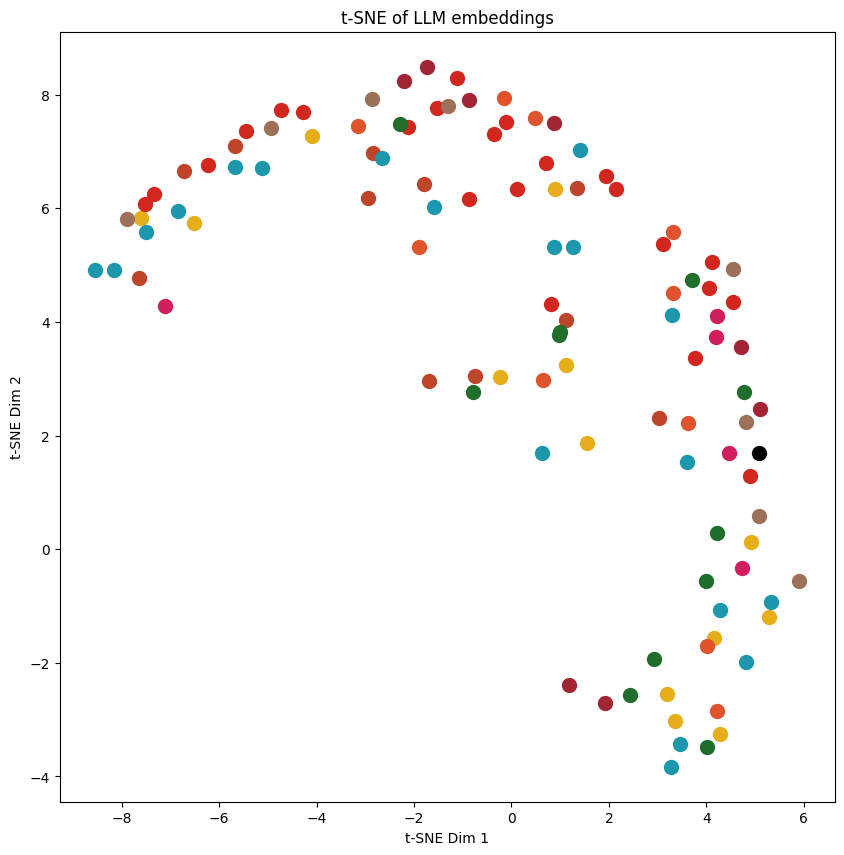

In [7]:
# pretained ALBERT
if albert_embeddings['pretrained'] is not None:
    plot_relative_embeddings(albert_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors)

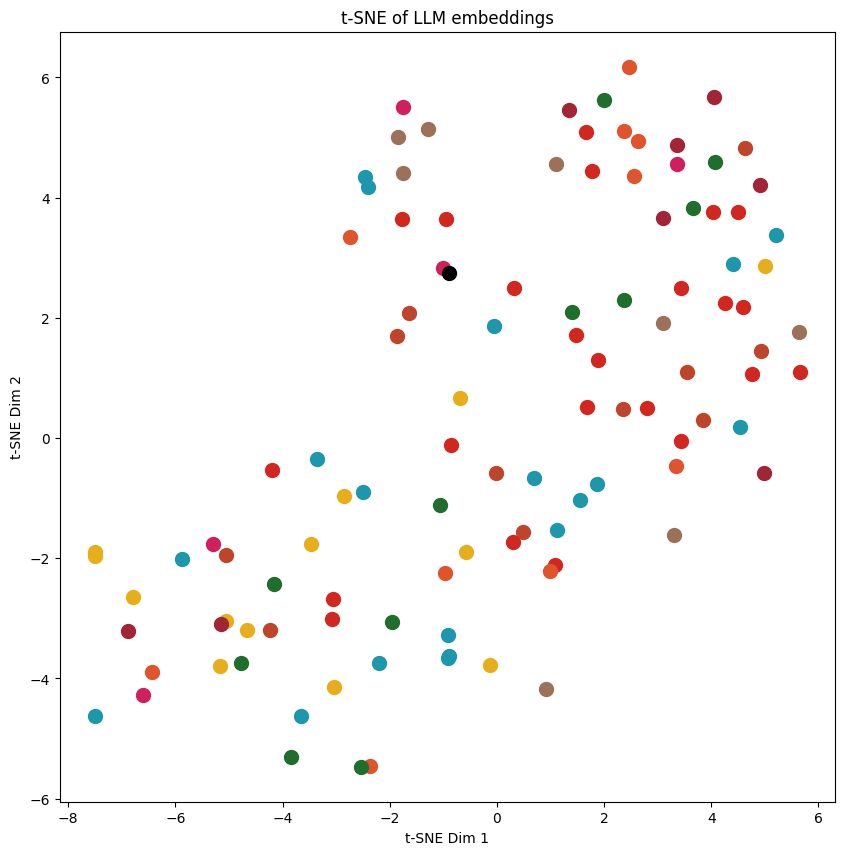

In [8]:
# finetuned ALBERT
if albert_embeddings['finetuned'] is not None:
    plot_relative_embeddings(albert_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors)

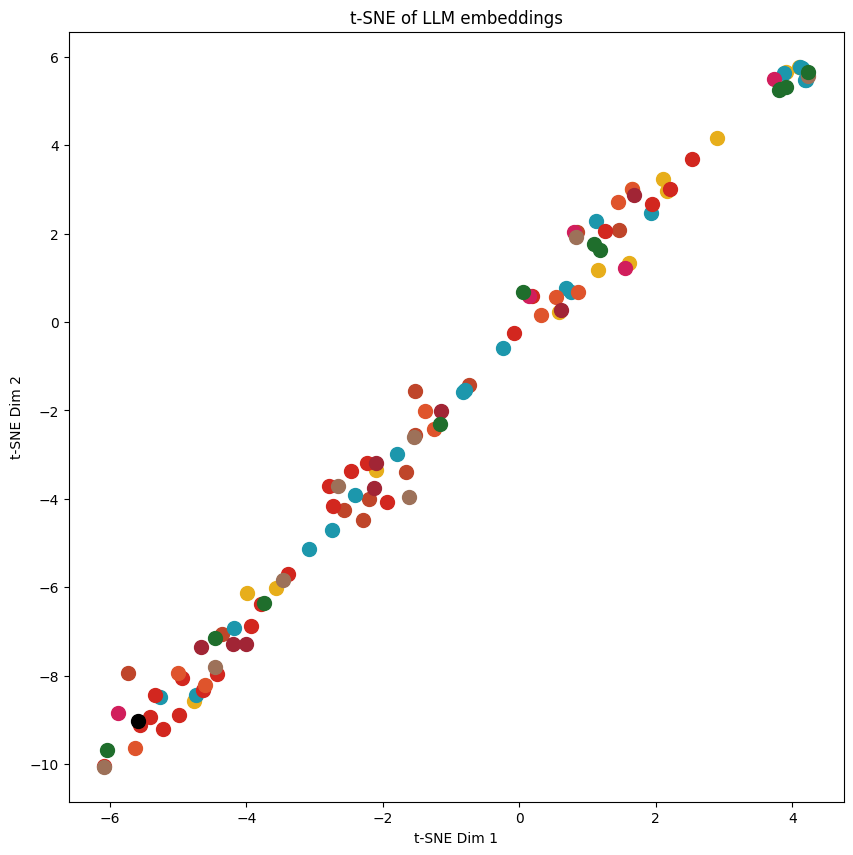

In [9]:
# pretained BART encoder
if bart_embeddings['pretrained'] is not None:
    plot_relative_embeddings(bart_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors)

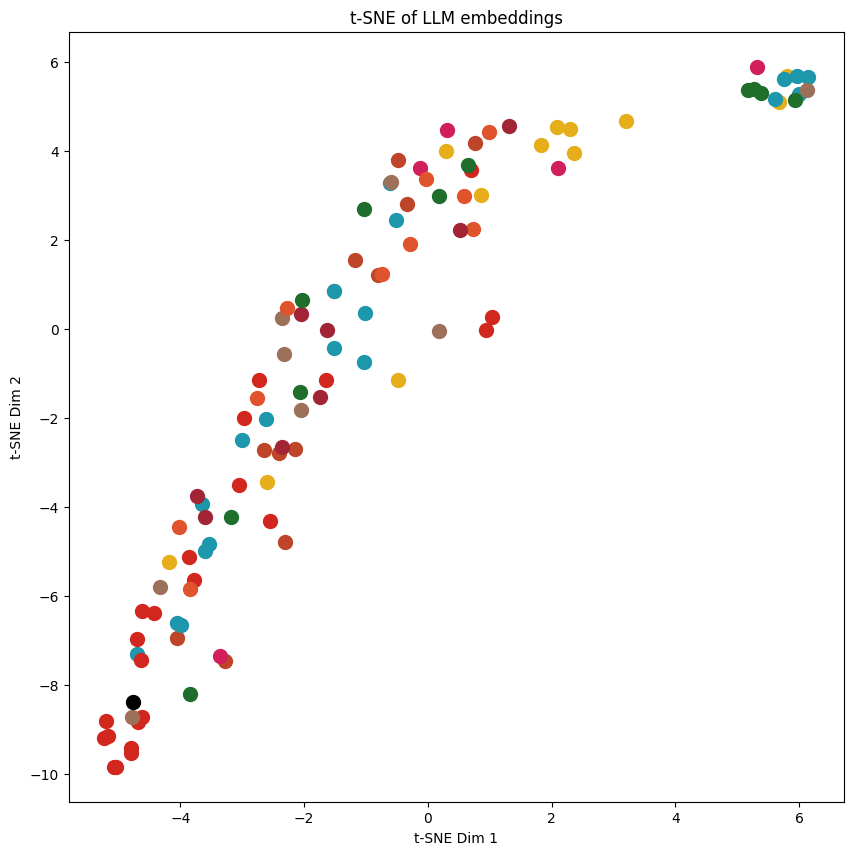

In [10]:
# finetuned BART encoder
if bart_embeddings['finetuned'] is not None:
    plot_relative_embeddings(bart_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors)

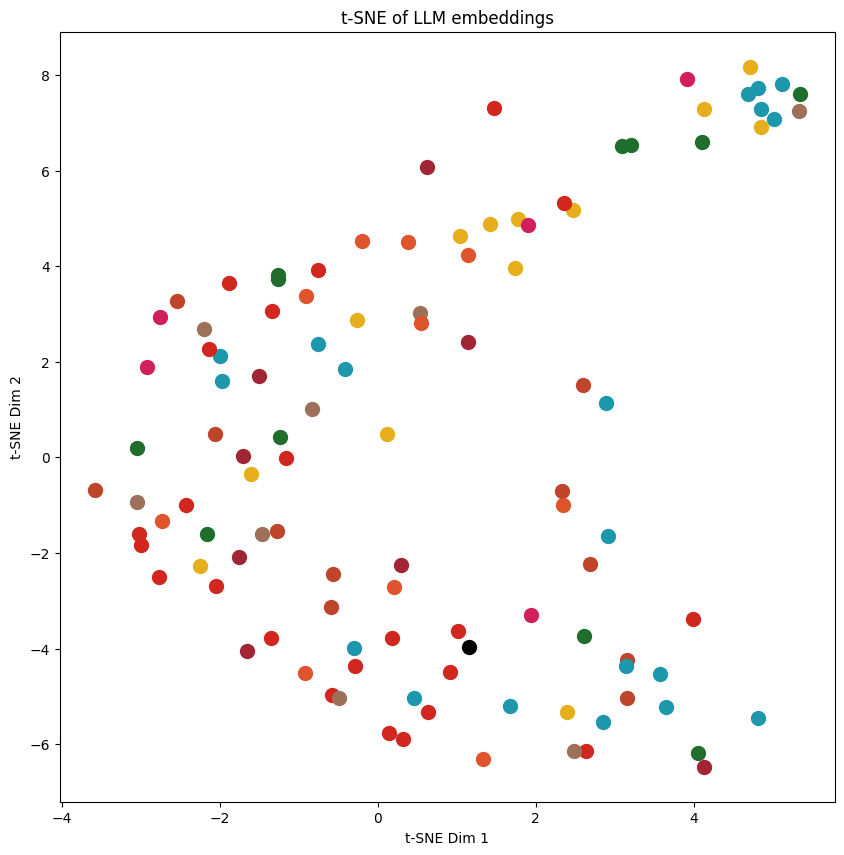

In [11]:
# pretained BART decoder
if bart_embeddings['pretrained'] is not None:
    plot_relative_embeddings(bart_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             description_colors)

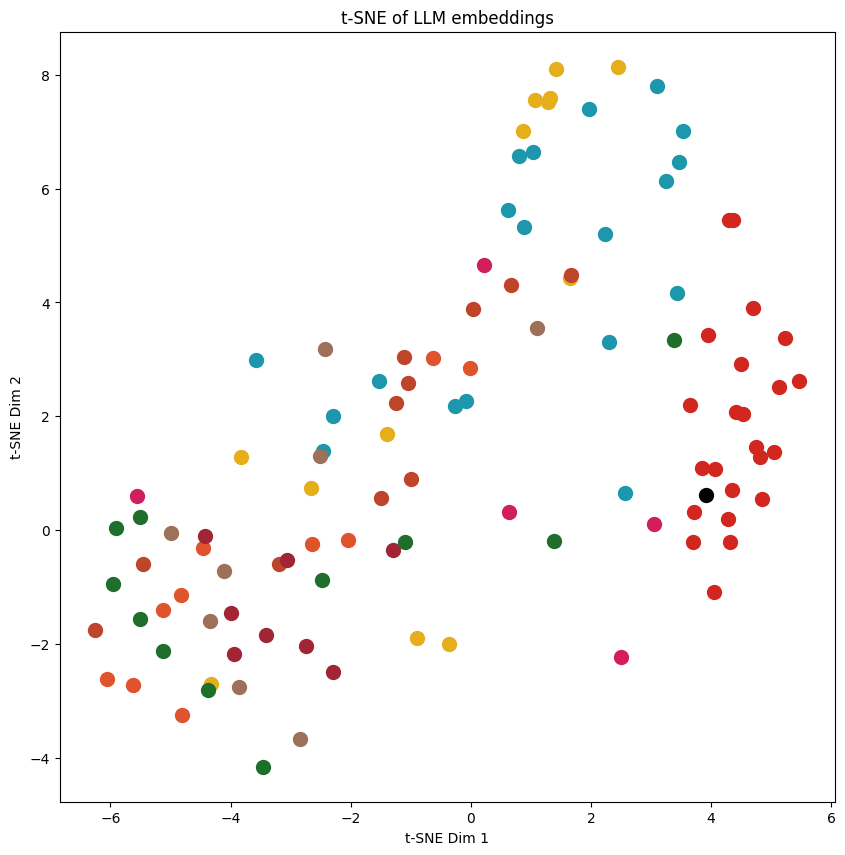

In [12]:
# finetuned BART decoder
if bart_embeddings['finetuned'] is not None:
    plot_relative_embeddings(bart_embeddings['finetuned'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             description_colors)

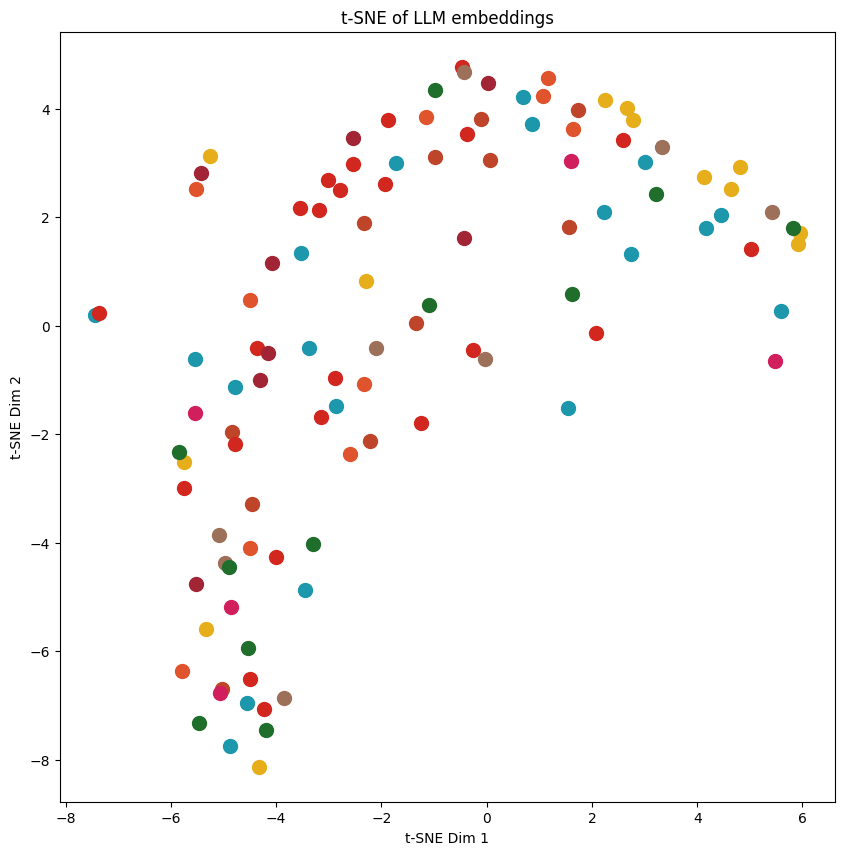

In [13]:
# use in journal
# pretained BERT (no OOD)
if bert_embeddings['pretrained'] is not None:
    plot_relative_embeddings(bert_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors,
                             plot_OOD = False)

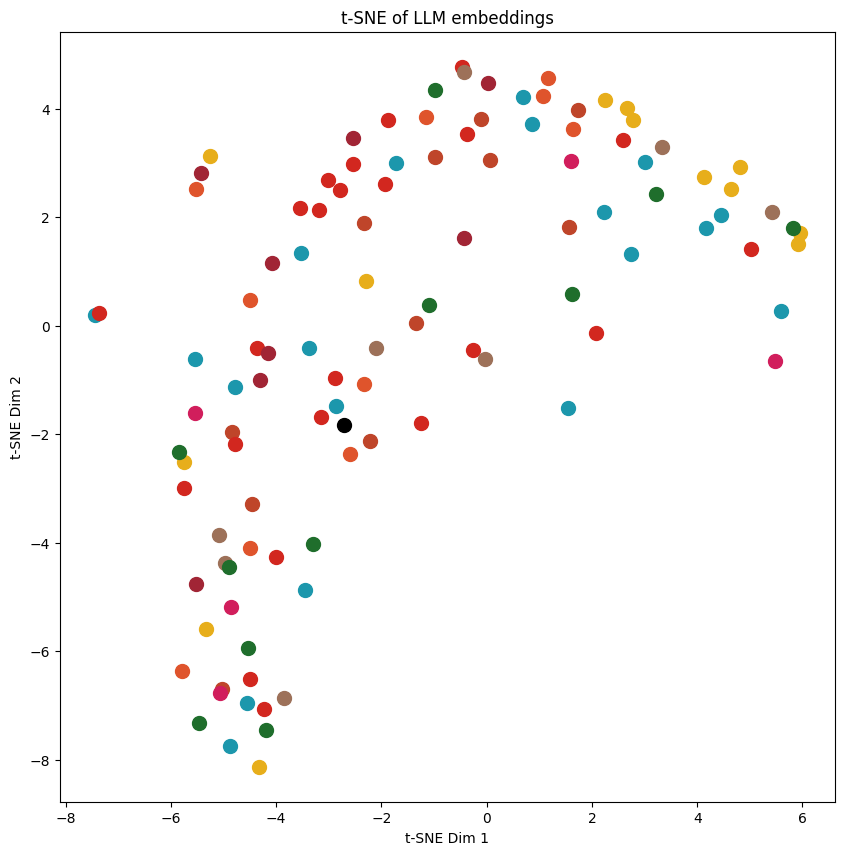

In [14]:
# use in journal
# pretained BERT
if bert_embeddings['pretrained'] is not None:
    plot_relative_embeddings(bert_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors)

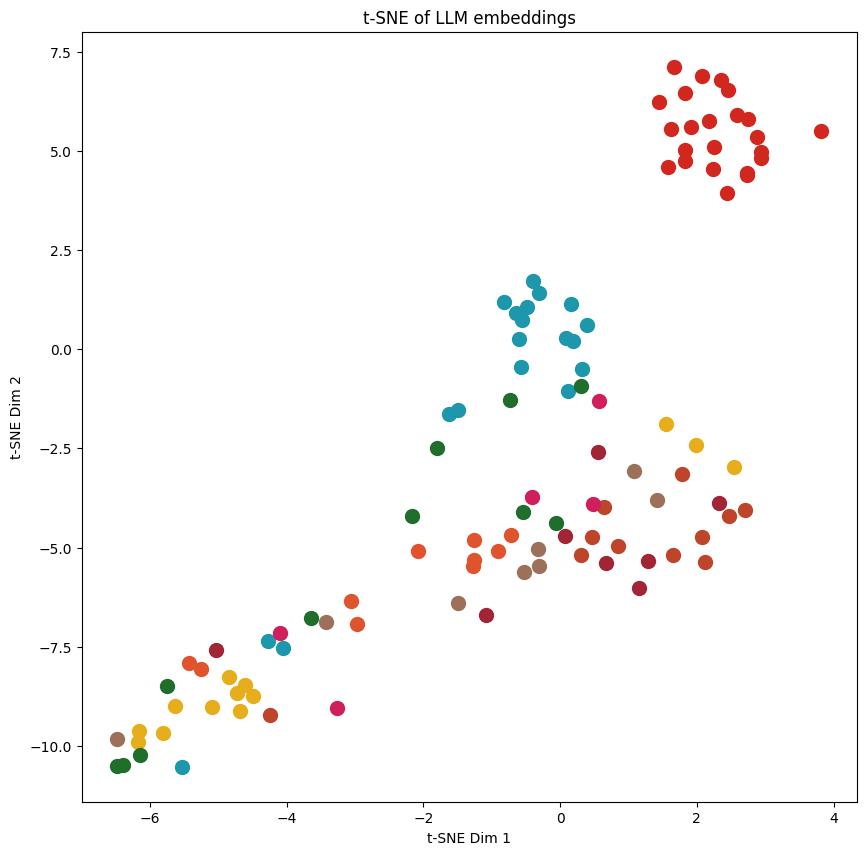

In [15]:
# use in journal
# finetuned BERT (no OOD)
if bert_embeddings['finetuned'] is not None:
    plot_relative_embeddings(bert_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors,
                             plot_OOD = False)

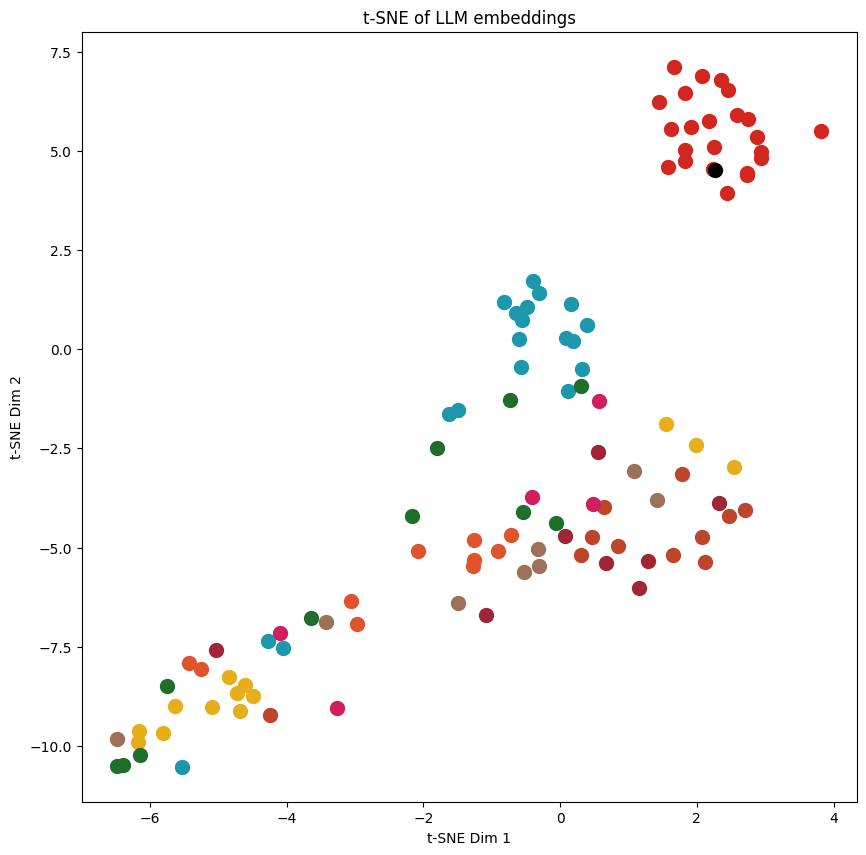

In [16]:
# use in journal
# finetuned BERT
if bert_embeddings['finetuned'] is not None:
    plot_relative_embeddings(bert_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors)

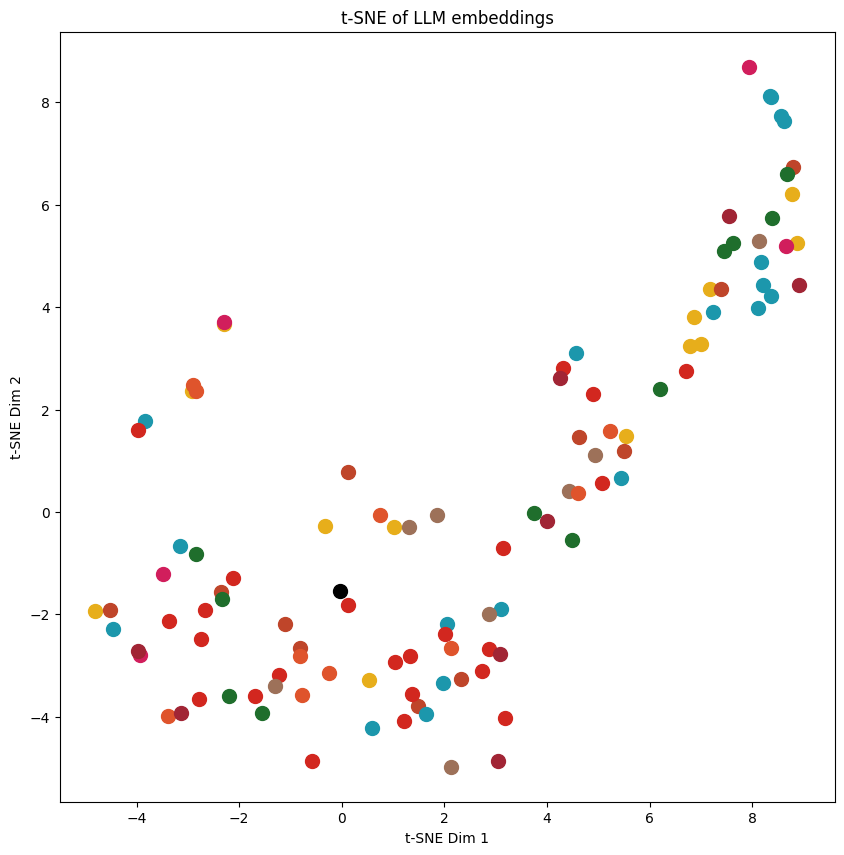

In [17]:
# pretained GPT
if gpt_embeddings['pretrained'] is not None:
    plot_relative_embeddings(gpt_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             description_colors)

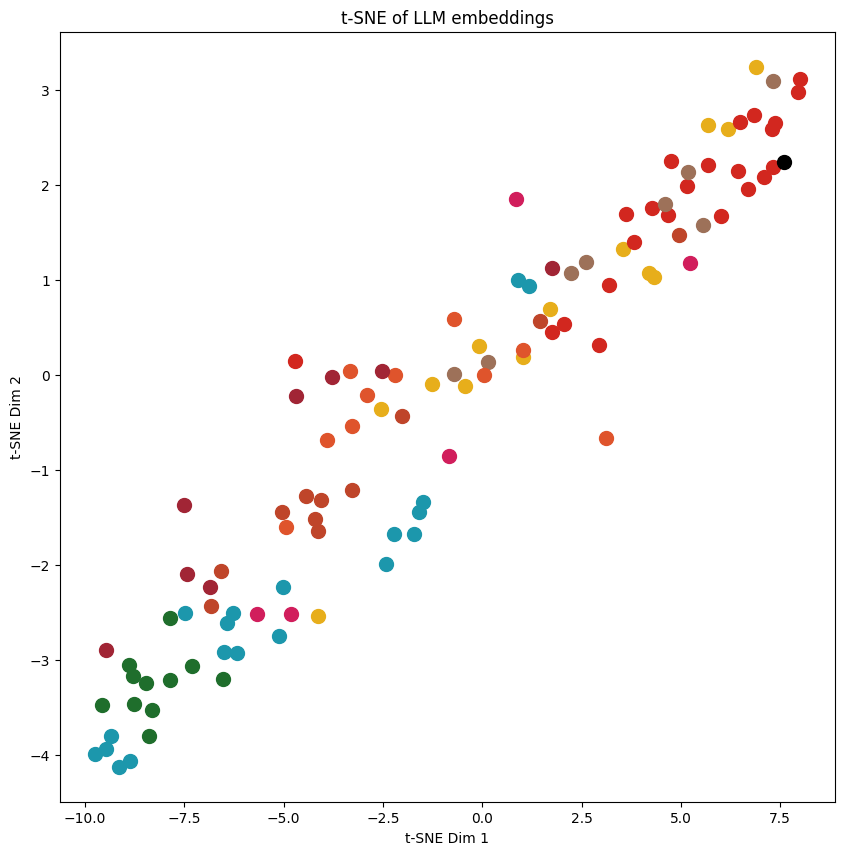

In [18]:
# pretained GPT
if gpt_embeddings['finetuned'] is not None:
    plot_relative_embeddings(gpt_embeddings['finetuned'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             description_colors)

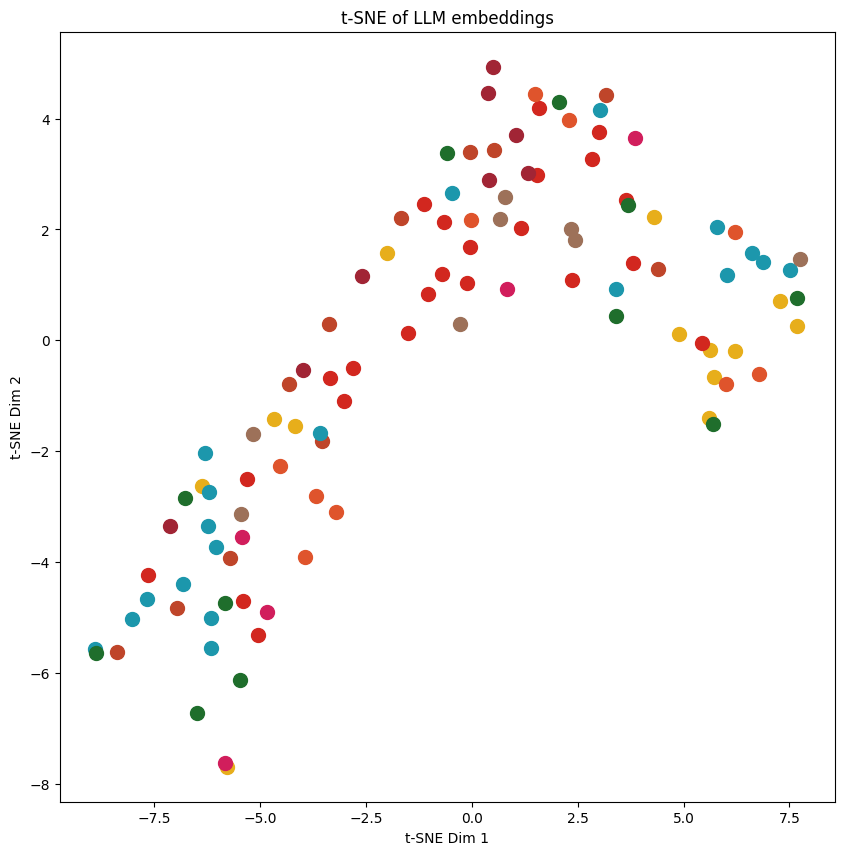

In [19]:
# use in journal
# pretained RoBERTa (no OOD)
if roberta_embeddings['pretrained'] is not None:
    plot_relative_embeddings(roberta_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors,
                             plot_OOD = False)

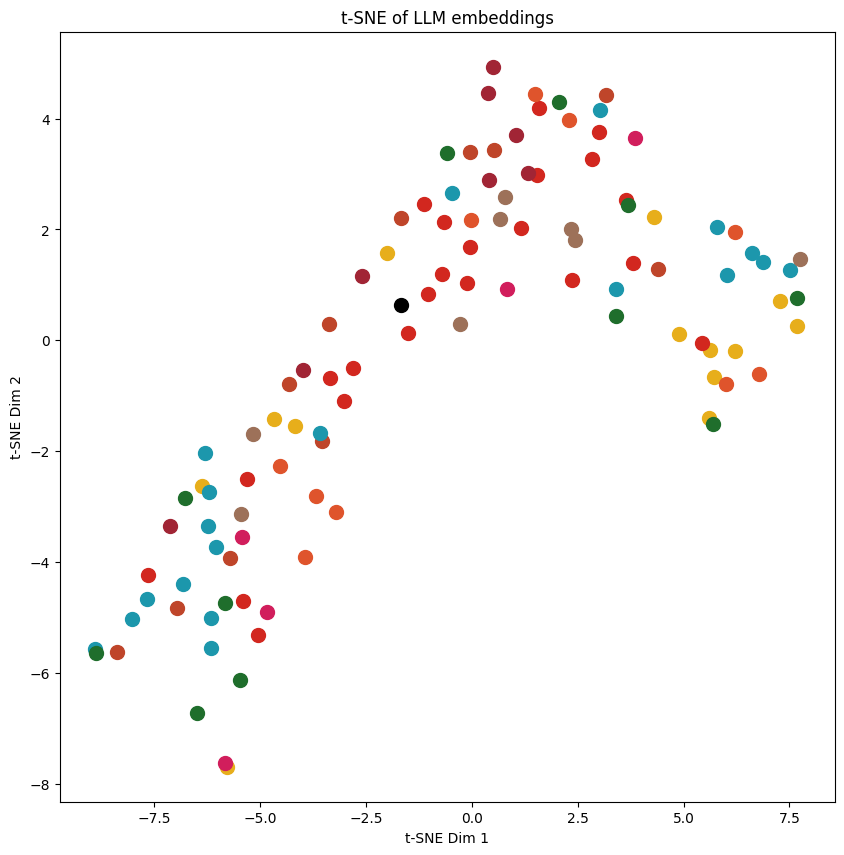

In [20]:
# use in journal
# pretained RoBERTa
if roberta_embeddings['pretrained'] is not None:
    plot_relative_embeddings(roberta_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors)

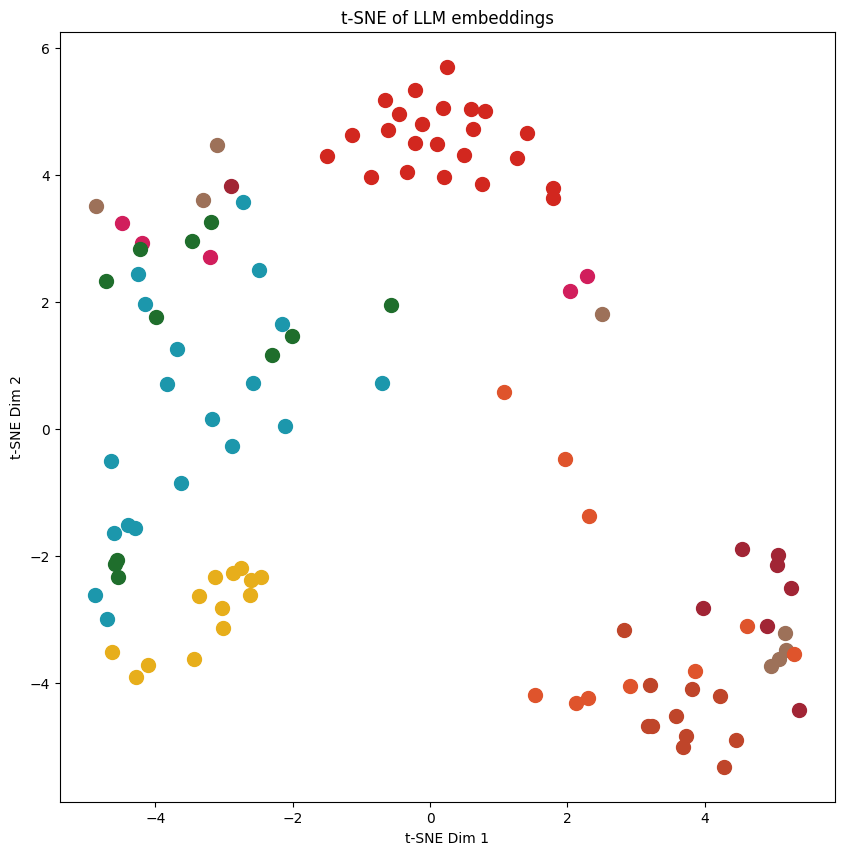

In [21]:
# use in journal
# finetuned RoBERTa (no OOD)
if roberta_embeddings['finetuned'] is not None:
    plot_relative_embeddings(roberta_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors,
                             plot_OOD = False)

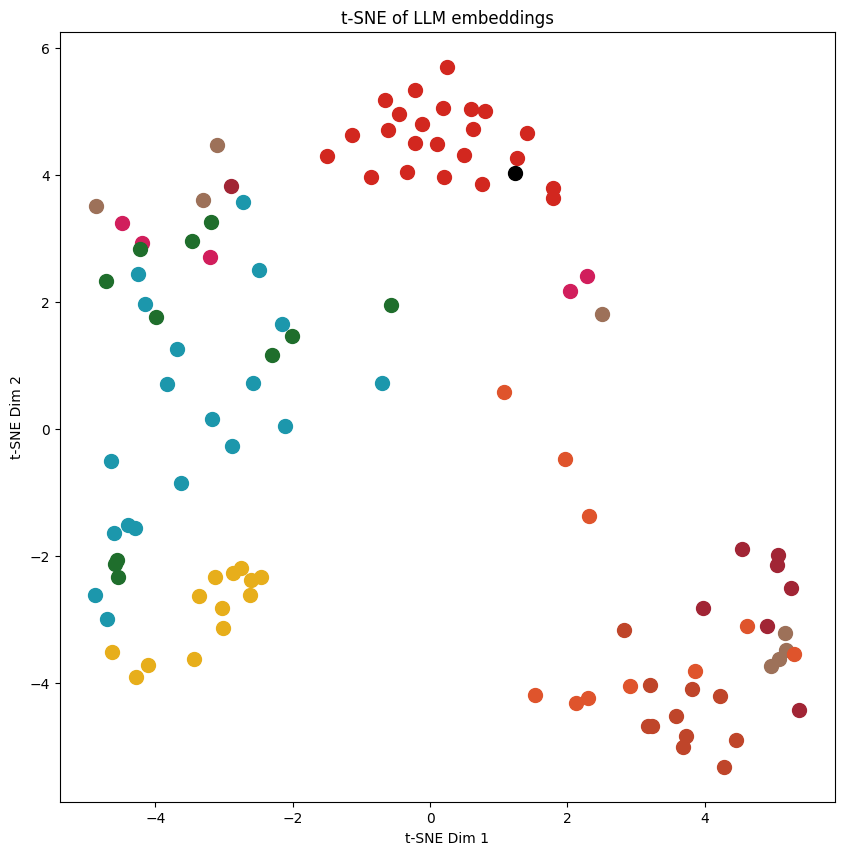

In [22]:
# use in journal
# finetuned RoBERTa
if roberta_embeddings['finetuned'] is not None:
    plot_relative_embeddings(roberta_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors)

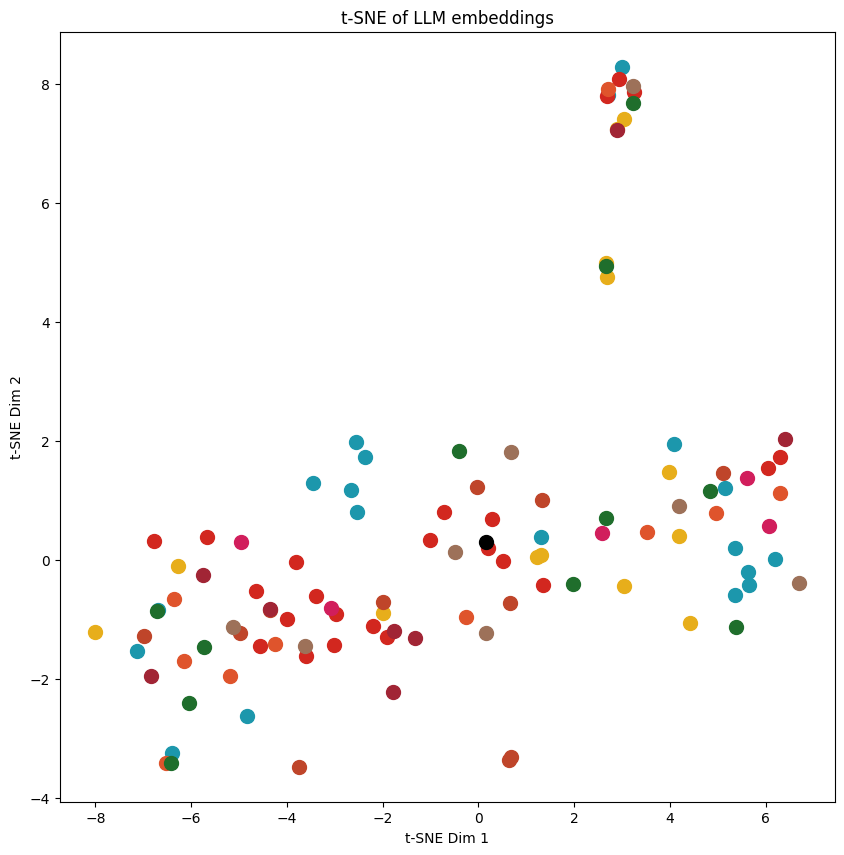

In [23]:
# pretained T5 encoder
if t5_embeddings['pretrained'] is not None:
    plot_relative_embeddings(t5_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors)

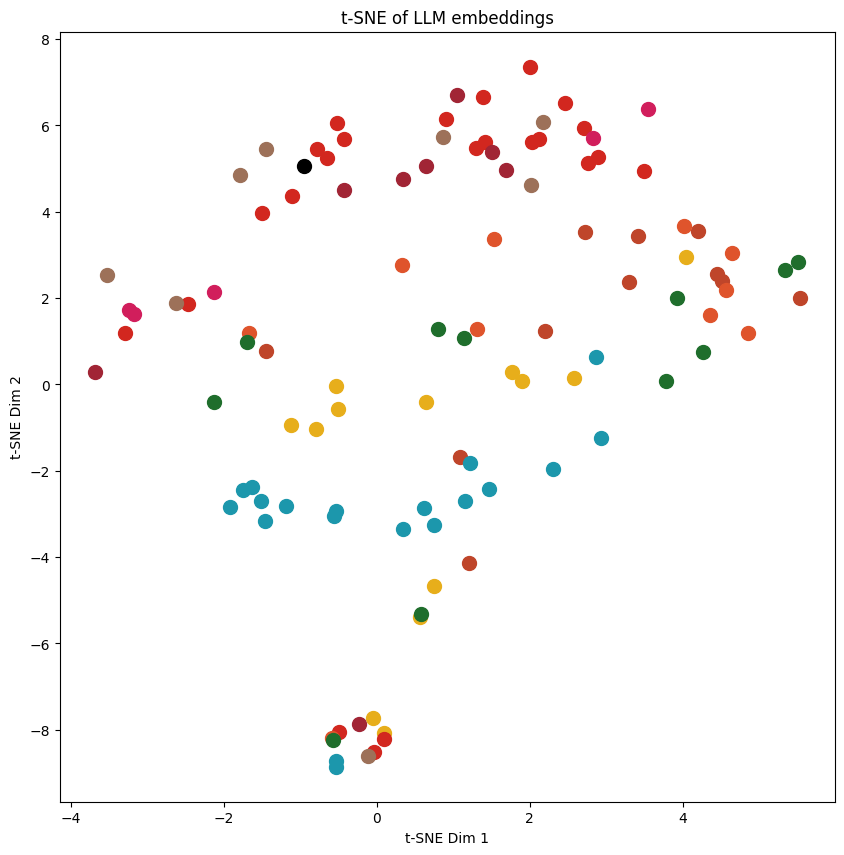

In [24]:
# finetuned T5 encoder
if t5_embeddings['finetuned'] is not None:
    plot_relative_embeddings(t5_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             description_colors)

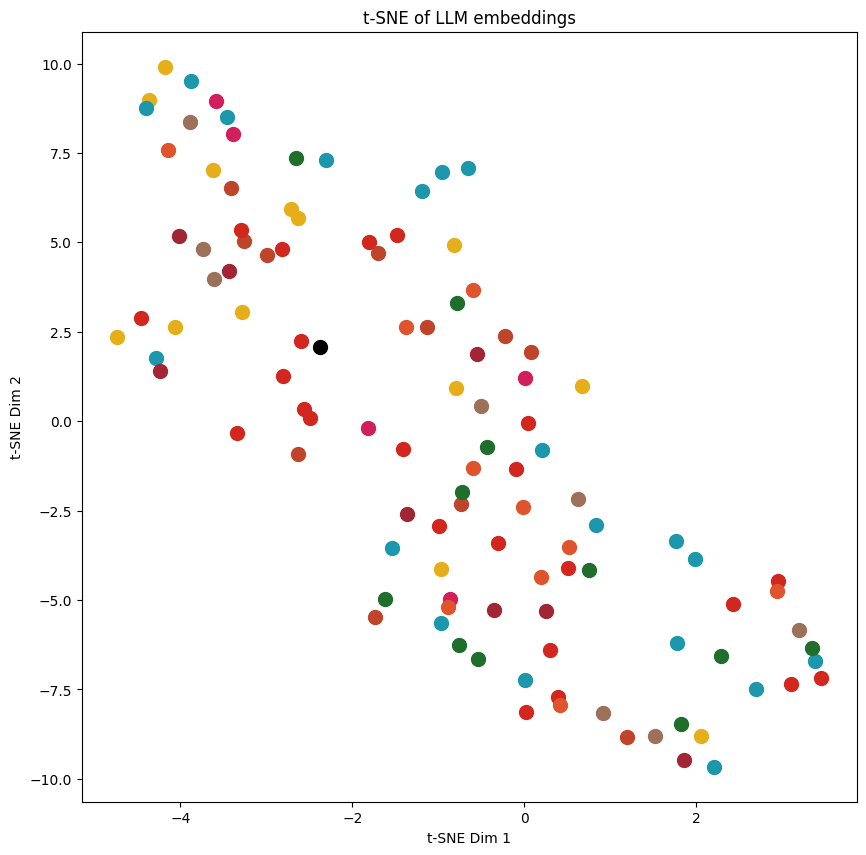

In [25]:
# pretained T5 decoder
if t5_embeddings['pretrained'] is not None:
    plot_relative_embeddings(t5_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             description_colors)

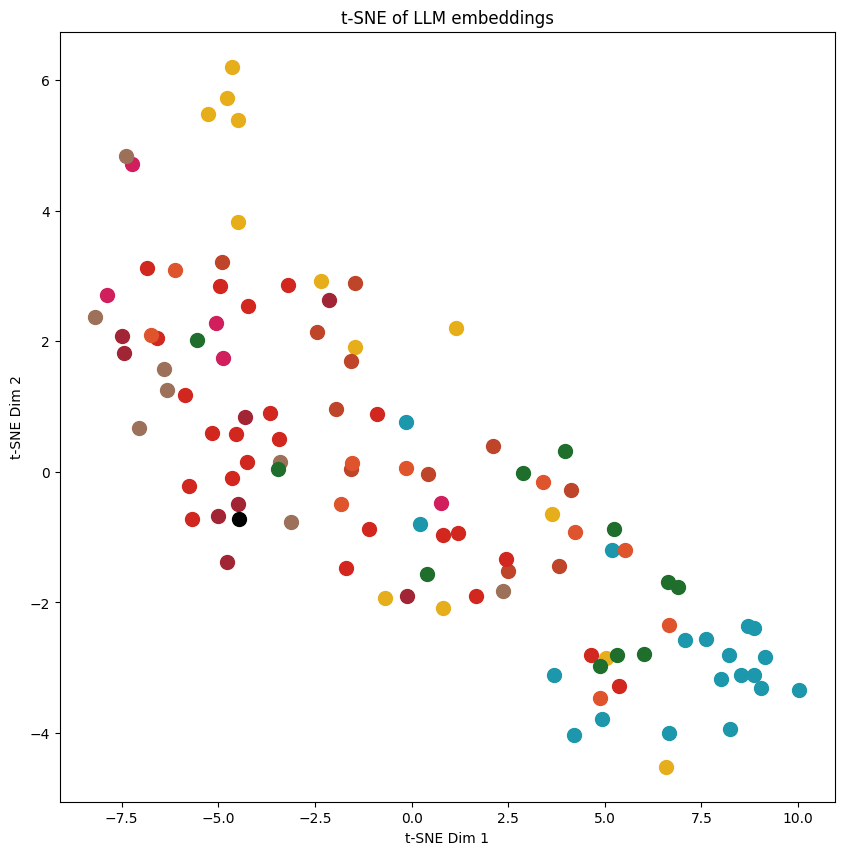

In [26]:
# finetuned T5 decoder
if t5_embeddings['finetuned'] is not None:
    plot_relative_embeddings(t5_embeddings['finetuned'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             description_colors)